In [419]:
#imports
import tensorflow as tf
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import util
import pickle
from random import randrange
import scipy
import math

In [506]:
#generate random chord with 1-6 notes
maxNotes = 6
noise_power = 70 #add white noise

#22 = G2, 53 = D5    D5 freq = 587, G2 freq = 98   (limit freqs?)
lower = 22
upper = 53

#generate numcols random columns from a spectrogram, return (col(s), freqInterval, ans[])
def gencols(numcols):
    cols = []
    
    #pick a random number of notes
    numNotes = randrange(maxNotes) + 1
    # numNotes = 7
    notes = []
    
    #generate notes
    for i in range(numNotes):
        rand = randrange(upper - lower + 1) + lower
        while rand in notes:
            rand = randrange(upper - lower + 1) + lower
        notes.append(rand)
    
    #compile sounds
    sound = AudioSegment.from_file("pianomonoindexed/" + str(notes[0]) + ".mp3", format="mp3")
    for i in range(1, numNotes):
        soundnew = AudioSegment.from_file("pianomonoindexed/" + str(notes[i]) + ".mp3", format="mp3")
        #add a randomized decibel offset between -10 and 5
        offset = randrange(15) - 10
        soundnew += offset
        sound = sound.overlay(soundnew, position=0)

    data = np.array(sound.get_array_of_samples())
    noise = np.int_(np.round(np.random.normal(scale=100, size=len(data))))
    data += noise
    
    #generate spectrum
    #plt.specgram for visual spectrum (uses more time)
    #spectrum, freqs, times, dot = plt.specgram(np.array(sound.get_array_of_samples()), Fs=sound.frame_rate, NFFT=8192)
    #plt.show()
    #scipy.signal.spectrogram for without visual graph (save time)
    freqs, times, spectrum = scipy.signal.spectrogram(np.array(sound.get_array_of_samples()), fs=sound.frame_rate, nperseg=8192)
    #with the current settings, spectrum = [4097, 2] (dimensions)
    
    #generate the answer array
    ans = []
    for i in range(upper - lower + 1):
        if (i + lower) in notes:
            ans.append(1)
        else:
            ans.append(0)
    
    if numcols == 1:
        randbool = randrange(1)
        return ([spectrum[:,randbool]], freqs[1], ans)
    else:
        return (np.transpose(spectrum), freqs[1], ans)

In [511]:
print(gencols(1))

([array([6.6804502e-04, 2.0532478e+02, 5.8135126e+02, ..., 5.8045553e-05,
       1.1715547e-05, 1.4302719e-07], dtype=float32)], 5.38330078125, [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


0 train
0 test
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


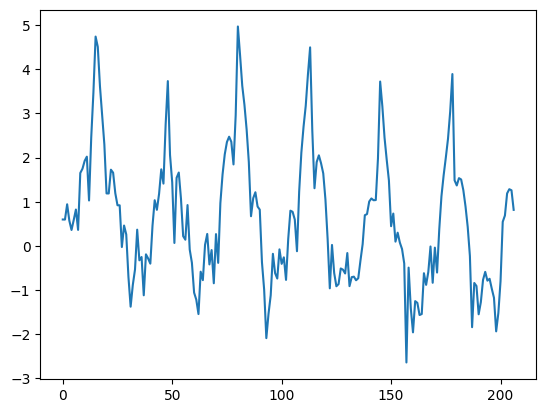

In [422]:
#create and serialize data
xtrain = []
ytrain = []
xtest = []
ytest = []

#data will have 1-6 note chords, only containing notes from G2 to D5 (inclusive)
numtrain = 1
numtest = 1

minfreq = 95
maxfreq = 1200
numcolsPerSample = 1


def normalize(arr):
    ##TODO LOGARIZE + NORMALIZE DATA
    return np.log10(arr)



for i in range(math.ceil(numtrain/numcolsPerSample)):
    columns, basefreq, ans = gencols(numcolsPerSample)
    for col in columns:
        #trim the desired frequncies
        lowerindex = math.floor(minfreq/basefreq)
        upperindex = math.ceil(maxfreq/basefreq)
        xtrain.append(normalize(col[lowerindex:upperindex + 1]))
    ytrain.append(ans)
    print(str(i) + " train")
    
for i in range(math.ceil(numtest/numcolsPerSample)):
    columns, basefreq, ans = gencols(numcolsPerSample)
    for col in columns:
        #trim the desired frequncies
        lowerindex = math.floor(minfreq/basefreq)
        upperindex = math.ceil(maxfreq/basefreq)
        xtest.append(normalize(col[lowerindex:upperindex + 1]))
    ytest.append(ans)
    print(str(i) + " test")

    
folder = "trainingdata/"
pickle.dump(xtrain, open(folder + "xtrain.p", "wb"))
plt.plot(xtrain[0])
print(ytrain[0])


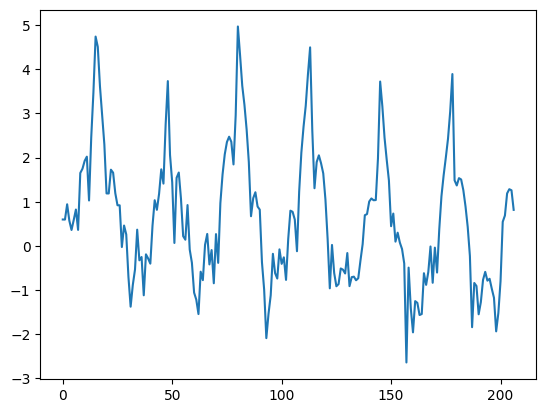

In [423]:
data = pickle.load(open(folder + "xtrain.p", "rb"))
plt.plot(data[0])

## Training
Note that ds3.pt contains 10^3 samples, etc

ds27.pt contains 100 samples all with 7 notes

In [424]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [428]:
batch_size = 100
ds = torch.load('ds4.pt')
train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:17<00:00,  2.57s/it]

0.0035993362311273814


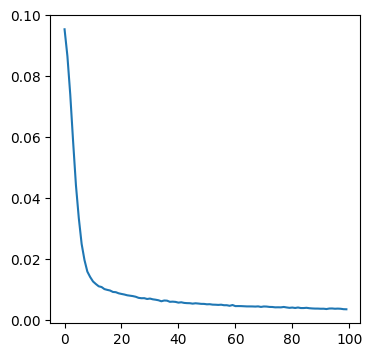

In [431]:
lr = 0.05
ep = 100
in_size = ds[0][0].shape[0]
out_size = ds[0][1].shape[0]
net = nn.Sequential(
  nn.Sigmoid(),
  nn.Linear(in_size, 400),
  nn.ReLU(),
  nn.Linear(400, 400),
  nn.ReLU(),
  nn.Linear(400, out_size)
)

loss_fcn = nn.MSELoss()
optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
losses = []

losses = []
for epoch in tqdm(range(ep)):
  total_items = 0
  total_loss = 0
  for x,t in train_dl:
    y = net.forward(x)
    loss = loss_fcn(y, t)
    total_loss += loss.item() * len(x)
    total_items += len(x)
    optim.zero_grad()
    loss.backward()
    optim.step()
  losses.append(total_loss / total_items)
plt.figure(figsize=(4,4))
plt.plot(losses)
print(losses[-1])

## Testing

In [545]:
test_ds = torch.load('ds3.pt')
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [548]:
correct = 0
stats = [[0] * 5 for _ in range(7)] # num_samples, perfects, missed, false positives
x,t = next(iter(test_dl))
y = net.forward(x)
yy, tt = y[0],  t[0]
for i in range(len(y)):
  yy, tt = torch.abs(torch.round(y[i] + 0.16)), t[i]
  note_count = (tt == 1.).sum().item() - 1
  row = stats[note_count]
  miss, fpos = 0, 0
  for i in range(32):
    if yy[i] < tt[i]: miss += 1
    elif yy[i] > tt[i]: fpos += 1
  row[1] += 1
  row[2] += (miss + fpos == 0)
  row[3] += miss
  row[4] += fpos
for i in range(len(stats)):
  stats[i][0] = i+1
print("notes\t count\t acc\t missed\t falsepos")
for count,row in enumerate(stats):
  for i in range(2, 5):
    if row[1] > 0:
      stats[count][i] = round(row[i] / row[1], 3)
  print('\t'.join(str(x) for x in stats[count]))

notes	 count	 acc	 missed	 falsepos
1	179	1.0	0.0	0.0
2	172	1.0	0.0	0.0
3	162	1.0	0.0	0.0
4	162	1.0	0.0	0.0
5	175	0.989	0.011	0.0
6	150	1.0	0.0	0.0
7	0	0	0	0
